In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
#keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
import sklearn.metrics as metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
      print(e)

train = pd.read_csv("./content/emnist-letters-train.csv",delimiter = ',')
mapp = pd.read_csv("./content/emnist-letters-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Map: %s" %(train.shape, mapp.shape))

1 Physical GPUs, 1 Logical GPUs
Train: (88799, 785), Map: (26, 2)


In [3]:
# Constants
HEIGHT = 28
WIDTH = 28


In [4]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train
print(train_x.shape,train_y.shape)

(88799, 784) (88799,)


In [5]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image


In [6]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)
# Normalise
train_x = train_x.astype('float32')

train_x: (88799, 28, 28)


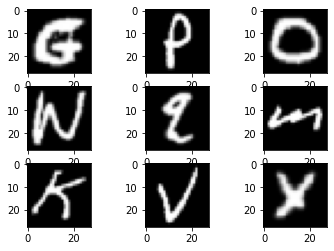

In [7]:
# plot image
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))

In [8]:
for i in range(0,((len(train_x)//64)*64)-64, 16):
    addv = []
    for j in range(4):
        addh = cv2.hconcat([train_x[i+j*8],train_x[i+j*8+1],train_x[i+j*8+2],train_x[i+j*8+3]
                            ,train_x[i+j*8+4],train_x[i+j*8+5],train_x[i+j*8+6],train_x[i+j*8+7]])
        addv.append(addh)
    addv=cv2.vconcat(addv)
    img = cv2.resize(addv, (256,256))
    cv2.imwrite(f'./content/{i}.png',img)

(224, 224)


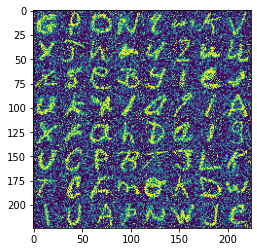

In [9]:
img = cv2.imread('./content/image.jpg', cv2.IMREAD_GRAYSCALE)/255
noise_factor = 0.5
x_train_noisy = img + noise_factor * tf.random.normal(shape=img.shape)
print(img.shape)
cv2.imwrite('./content/noisy.jpg', (x_train_noisy).numpy()*255)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
plt.imshow(x_train_noisy)


In [10]:
from tensorflow.keras.utils import Sequence
import math

class Dataloader(Sequence):

    def __init__(self, x_set, batch_size, shuffle=False):
        self.x, self.y = x_set, x_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __data_generation(self, X_list, Y_list):
        X = np.empty((self.batch_size, 256,256, 1))
        Y = np.empty((self.batch_size, 256,256, 1))
        if Y is not None:
            for index, (xpath,ypath) in enumerate(zip(X_list,Y_list)):
                img = cv2.imread(xpath, cv2.IMREAD_GRAYSCALE)
                noise_factor = 0.5
                img = img / 255.0
                x_train_noisy = img + noise_factor * tf.random.normal(shape=img.shape)
                x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
                X[index, :, :, ] = x_train_noisy[...,np.newaxis]
                Y[index, :, :, ] = img[...,np.newaxis]
            return X, Y

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
				# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
        X, Y = self.__data_generation(batch_x,batch_y)
        return X, Y

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [11]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 1)),
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [12]:
import glob
inputs = glob.glob('./content/*.png')
print(len(inputs))

train_loader = Dataloader(inputs, 64, shuffle=True)

5544


In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [14]:
autoencoder.fit(train_loader,epochs=15)


Epoch 1/15
87/87 [==============================] - 17s 190ms/step - loss: 0.1644

In [15]:
autoencoder.save("Model_v1", save_format='tf')

INFO:tensorflow:Assets written to: Model_v1\assets


In [10]:
loaded_tfkmodel = tf.keras.models.load_model('./Model_v1')
loaded_tfkmodel.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 1)       145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
test_img=cv2.imread('./content/image.jpg', cv2.IMREAD_GRAYSCALE)
test_img=cv2.resize(test_img,(256,256))
print(test_img.shape)
encoded_imgs = loaded_tfkmodel(test_img[np.newaxis,...,np.newaxis]/255).numpy()
print(tf.squeeze(encoded_imgs).shape)

(256, 256)
(256, 256)


True

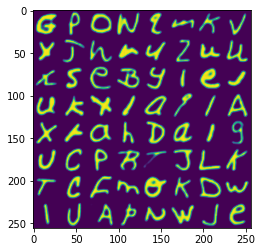

In [18]:
plt.imshow(tf.squeeze(encoded_imgs)*255)
cv2.imwrite('./content/test.jpg',np.array(tf.squeeze(encoded_imgs)*255))
